gg-napari-env

In [122]:
import napari
from napari_czifile2 import napari_get_reader
from cellpose import models, plot, utils, core, models, train
from cellpose.io import logger_setup
import cellpose.io as cio 
import torch 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import find_contours
import pandas as pd
import skimage.exposure as exposure
from skimage.morphology import remove_small_objects
import numpy as np
from skimage.measure import label, regionprops
import seaborn as sns
import os 
import sys 
from skimage.transform import resize
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold
from skimage.exposure import equalize_adapthist
from skimage.measure import label, regionprops
from scipy.ndimage import binary_erosion, gaussian_filter, binary_dilation, binary_fill_holes
from skimage import exposure
import sys 
import xml.etree.ElementTree as ET
from plotting import * 
white_plotting()
import warnings
import matplotlib.font_manager as fm
fm.fontManager.__init__()
warnings.filterwarnings("ignore")
use_GPU = core.use_gpu()
torch.cuda.empty_cache()
print('>>> GPU activated? %d'%use_GPU)
logger_setup()

2025-04-04 11:06:30,859 [INFO] Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: Could not set the fontsize (invalid pixel size; error code 0x17)
2025-04-04 11:06:30,918 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1
2025-04-04 11:06:30,920 [INFO] WRITING LOG OUTPUT TO /home/tracking/.cellpose/run.log
2025-04-04 11:06:30,921 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.12.8 
torch version:  	2.5.1+cu124


(<Logger cellpose.io (INFO)>, PosixPath('/home/tracking/.cellpose/run.log'))

In [123]:
def plot_2_channels(results, c1, c2, c1_name, c2_name, c1_color, c2_color, coordinates, 
                    image, metadata, all_rois, cell_borders, input, file, 
                    pixel_bounds=100, bbox_expansion=7, 
                    dapi_max=255, c1_max=255, c2_max=255): 
    
    # Remove -T from column names
    results.columns = results.columns.str.split('-T').str[0]

    # Make figure directory
    figure_dir = f'../figures/model_B_only_OSNs/{input}/{file.replace(".czi", "")}-{c1_name}-{c2_name}'
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)

    # Clear directory
    for f in os.listdir(figure_dir):
        os.remove(os.path.join(figure_dir, f))

    # Scatter Plot 
    f, ax = plt.subplots(1, 1, figsize=(2, 2), dpi = 400) 
    sns.scatterplot(data=results, x=c1, y=c2, s=10, ax=ax, color='black', alpha=0.3, lw=0)

    # Plot coordinates using the data from the image 
    results_image = results[results['image'] == file].reset_index(drop=True)
    random_colors = sns.color_palette('colorblind', len(coordinates))
    cells = [] 
    for i, coord in enumerate(coordinates): 
        cell_idx = np.argmin(np.linalg.norm(results_image[[c1, c2]].values - coord, axis=1))
        cell = results_image.iloc[cell_idx].copy()  
        sns.scatterplot(data=pd.DataFrame([cell]), x=c1, y=c2, color=random_colors[i], s=30, ax=ax, lw=0, alpha=1)
        cell["color"] = random_colors[i] 
        cell["number"] = i + 1
        cells.append(cell)
    cells = pd.DataFrame(cells)

    # Plotting 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"Normalized {c1_name} Intensity", fontsize=6) 
    ax.set_ylabel(f"Normalized {c2_name} Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-scatter.png", format="png", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

    # Get scale for scale bar 
    x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

    def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

    # Remove -border from c1 and c2 names
    c1 = c1.split('-border')[0]
    c2 = c2.split('-border')[0]

    channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]
    channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", c1, c2]])]

    for i, cell in cells.iterrows():
        # Retrieve image and z slice 
        x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
        y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
        cell_image = image[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)

        # Create composite RGB image
        rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

        # -- DAPI (Grey): add to all channels
        dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
        dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
        rgb_image[..., 0] += dapi_adjusted  # Red
        rgb_image[..., 1] += dapi_adjusted  # Green
        rgb_image[..., 2] += dapi_adjusted  # Blue

        # C1 
        c1_index = [idx for idx, channel in channels if c1 in channel][0]
        c1_adjusted = set_min_max(cell_image[c1_index], 0, c1_max) 
        if c1_color == "magenta": 
            rgb_image[..., 0] += c1_adjusted  
            rgb_image[..., 2] += c1_adjusted  
        elif c1_color == "cyan": 
            rgb_image[..., 1] += c1_adjusted
            rgb_image[..., 2] += c1_adjusted
        elif c1_color == "yellow": 
            rgb_image[..., 0] += c1_adjusted
            rgb_image[..., 1] += c1_adjusted

        # -- Cyan (c2): add to green and blue
        c2_index = [idx for idx, channel in channels if c2 in channel][0]
        c2_adjusted = set_min_max(cell_image[c2_index], 0, c2_max)
        if c2_color == "magenta": 
            rgb_image[..., 0] += c2_adjusted  
            rgb_image[..., 2] += c2_adjusted  
        elif c2_color == "cyan": 
            rgb_image[..., 1] += c2_adjusted
            rgb_image[..., 2] += c2_adjusted
        elif c2_color == "yellow": 
            rgb_image[..., 0] += c2_adjusted
            rgb_image[..., 1] += c2_adjusted

        # Normalize composite image to [0,1]
        rgb_image = np.clip(rgb_image/255, 0, 1)

        # Load ROIs and compute bbox (adjusted relative to the cell image)
        regions = regionprops(all_rois[cell['z'], :, :])
        region_labels = [region.label for region in regions]
        region = regions[region_labels.index(cell['z_id'])]
        bbox = region.bbox
        # Expand bbox by bbox_expansion pixels     
        bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
                bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
        # Adjust bbox to cell_image coordinates
        bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
                bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
        # For clarity, unpack bbox (top, left, bottom, right)
        y1, x1, y2, x2 = bbox

        # Create figure with gridspec: main image in left column (spanning all rows) 
        # and three zoom panels in the right column (each taking 1/3 height)
        # Adjust fig size and width ratios as needed.
        fig_width = 1   # total width (main image + zoom panels)
        fig_height = 0.75  # height of the main image (zoom panels share this height)
        f = plt.figure(figsize=(fig_width, fig_height), dpi=400)
        gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[4, 1])
        ax_main = f.add_subplot(gs[:, 0])
        ax_zoom_gray = f.add_subplot(gs[0, 1])
        ax_zoom_magenta = f.add_subplot(gs[1, 1])
        ax_zoom_cyan = f.add_subplot(gs[2, 1])

        # Plot main composite image
        ax_main.imshow(rgb_image)
        ax_main.axis("off")
        # Add border to main image
        ax_main.add_patch(plt.Rectangle((0, 0), cell_image.shape[2]-1, cell_image.shape[1]-1, fill=False, edgecolor=cell['color'], lw=2))
        # Add text legends on main image
        ax_main.text(5, 25, "DAPI", color='white', fontsize=6, weight='bold')
        ax_main.text(5, 45, c1_name, color=c1_color, fontsize=6, weight='bold')
        ax_main.text(5, 65, c2_name, color=c2_color, fontsize=6, weight='bold')
        # Add scale bar on main image
        ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                    [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
        
        ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

        # ----- Create zoom panels -----
        # Zoom for Grey (DAPI)
        zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
        # Build RGB image: all channels get the DAPI intensity
        dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
        dapi_zoom[..., 0] = zoom_dapi
        dapi_zoom[..., 1] = zoom_dapi
        dapi_zoom[..., 2] = zoom_dapi
        dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
        ax_zoom_gray.imshow(dapi_zoom)
        ax_zoom_gray.axis("off")
        ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))
        
        # Plot cell border on zoom panel in red 
        # Get cell border 
        cell_border = cell_borders[cell['z'], :, :] == cell['z_id']
        cell_border = cell_border[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
        cell_border = cell_border[y1:y2, x1:x2]
        # Make background transparent and set cell border pixels to red 
        cell_border_rgba = np.zeros((cell_border.shape[0], cell_border.shape[1], 4), dtype=float)
        cell_border_rgba[cell_border, 0] = 1 # Red channel
        cell_border_rgba[cell_border, 3] = 0.5 # Alpha channel
        # Plot RGBA image on top of the same zoom panel
        ax_zoom_gray.imshow(cell_border_rgba, alpha=1)

        # Zoom for Magenta (c1)
        zoom_c1 = c1_adjusted[y1:y2, x1:x2]
        # Build an RGB image: red and blue channels from c1
        zoom_c1_rgb = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
        if c1_color == "magenta": 
            zoom_c1_rgb[..., 0] += zoom_c1  
            zoom_c1_rgb[..., 2] += zoom_c1  
        elif c1_color == "cyan": 
            zoom_c1_rgb[..., 1] += zoom_c1
            zoom_c1_rgb[..., 2] += zoom_c1
        elif c1_color == "yellow": 
            zoom_c1_rgb[..., 0] += zoom_c1
            zoom_c1_rgb[..., 1] += zoom_c1
        zoom_c1_rgb = np.clip(zoom_c1_rgb/255, 0, 1)
        ax_zoom_magenta.imshow(zoom_c1_rgb)
        ax_zoom_magenta.axis("off")
        ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor=c1_color, lw=1))
        ax_zoom_magenta.imshow(cell_border_rgba, alpha=0.5)

        # Zoom for Cyan (c2)
        zoom_c2 = c2_adjusted[y1:y2, x1:x2]
        # Build an RGB image: green and blue channels from c2
        zoom_c2_rgb = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
        if c2_color == "magenta": 
            zoom_c2_rgb[..., 0] += zoom_c2  
            zoom_c2_rgb[..., 2] += zoom_c2  
        elif c2_color == "cyan": 
            zoom_c2_rgb[..., 1] += zoom_c2
            zoom_c2_rgb[..., 2] += zoom_c2
        elif c2_color == "yellow": 
            zoom_c2_rgb[..., 0] += zoom_c2
            zoom_c2_rgb[..., 1] += zoom_c2
        zoom_c2_rgb = np.clip(zoom_c2_rgb/255, 0, 1)
        ax_zoom_cyan.imshow(zoom_c2_rgb)
        ax_zoom_cyan.axis("off")
        ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor=c2_color, lw=1))
        ax_zoom_cyan.imshow(cell_border_rgba, alpha=0.5)

        plt.tight_layout(pad=0)
        #plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-cell_{cell["number"]}.png", format="png", pad_inches=0, bbox_inches='tight', transparent=False)
        plt.show()

In [124]:
def parse_marker_file_z_major(xml_file_path, num_channels):
    """
    Parses an ImageJ Cell Counter XML marker file where Z indices are flattened
    assuming Z-major ordering (Z slices vary fastest, channels slowest), and
    the flattened indices (MarkerZ) are 1-based.

    MarkerZ was calculated in ImageJ as:
        MarkerZ = (z - 1) * num_channels + (channel - 1) + 1
                = 1-based linear index assuming Z-major ordering.

    This function reverses that logic to recover the true Z slice and channel
    as 0-based indices:

        z = (MarkerZ - 1) // num_channels
        channel = (MarkerZ - 1) % num_channels

    Parameters:
    -----------
    xml_file_path : str
        Path to the XML file exported from the ImageJ Cell Counter plugin.

    num_channels : int
        The number of image channels (e.g., 4 if using DAPI, 488, 546, 647).

    Returns:
    --------
    pandas.DataFrame
        A DataFrame with the following columns:
            - 'name'    : The marker type name from the XML (e.g., "488C")
            - 'x'       : Marker X coordinate
            - 'y'       : Marker Y coordinate
            - 'z'       : Recovered Z slice index (0-based)
            - 'channel' : Recovered channel index (0-based)
            - 'image'   : Inferred image filename from XML name
            - 'cytoplasmic' : Derived label from marker name (e.g., "AF488")

    Notes:
    ------
    This has been validated with a test placing markers on:
        - z=1, c=1 → MarkerZ = 1
        - z=1, c=2 → MarkerZ = 2
        - z=1, c=3 → MarkerZ = 3
        - z=2, c=1 → MarkerZ = 4
        - z=2, c=2 → MarkerZ = 5
        - z=2, c=3 → MarkerZ = 6

    The function correctly recovers:
        - z = 0-based z index (e.g., MarkerZ = 4 → z=1)
        - channel = 0-based channel index (e.g., MarkerZ = 4 → channel=0)
    """
    import xml.etree.ElementTree as ET
    import pandas as pd

    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    data = []
    for marker_type in root.findall(".//Marker_Type"):
        name = marker_type.findtext("Name")
        for marker in marker_type.findall("Marker"):
            x = int(marker.findtext("MarkerX"))
            y = int(marker.findtext("MarkerY"))
            z_raw = int(marker.findtext("MarkerZ"))

            # Adjust for 1-based MarkerZ
            z_index = z_raw - 1
            z = z_index // num_channels        # 0-based Z slice
            channel = z_index % num_channels   # 0-based channel index

            data.append({
                'name': name,
                'x': x,
                'y': y,
                'z': z,
                'channel': channel
            })

    df = pd.DataFrame(data)
    df['image'] = xml_file_path.split('CellCounter_')[1].replace('.xml', '.czi')
    df['cytoplasmic'] = df['name'].apply(lambda x: "AF" + x.split("C")[0])
    return df


In [177]:
def load_cytoplasmic_cell_counts(input, channels, channel_names, normalization=0.00001): 
    results_dir = f'../results/{input}'
    results_files = os.listdir(results_dir)
    results_files = [f for f in results_files if f.endswith('borders.csv')]

    # Load all results 
    results = pd.DataFrame() 
    for f in results_files:
        results_path = os.path.join(results_dir, f)
        results_individual = pd.read_csv(results_path)
        results_individual.columns = results_individual.columns.str.split('-T').str[0]
        results = pd.concat([results, results_individual], axis=0) 
    results = results.reset_index(drop=True)
    
    for sample in results['image'].unique():
        results_sample = results[results['image'] == sample]
        for channel in channels: 
            nuclear_and_cytoplasmic = pd.concat([results_sample[channel], results_sample[channel + "-border"]], axis=0)
            lower = nuclear_and_cytoplasmic.quantile(normalization)
            upper = nuclear_and_cytoplasmic.quantile(1-normalization)
            results_sample[channel] = (results_sample[channel] - lower) / (upper - lower)
            results_sample[channel + "-border"] = (results_sample[channel + "-border"] - lower) / (upper - lower)
        results.loc[results['image'] == sample] = results_sample
    
    """channels_to_normalize = channels + [channels[i] + "-border" for i in range(len(channels))] 
    for sample in results['image'].unique():
        results_sample = results[results['image'] == sample]
        for channel in channels_to_normalize: 
            lower = results_sample[channel].quantile(normalization)
            upper = results_sample[channel].quantile(1-normalization)
            results_sample[channel] = (results_sample[channel] - lower) / (upper - lower)
        results.loc[results['image'] == sample] = results_sample"""

    cell_counts_dir = f'../cytoplasmic-markers/{input}'
    cell_counts_files = os.listdir(cell_counts_dir)
    cellcounts = [] 
    for f in cell_counts_files:
        xml_path = os.path.join(cell_counts_dir, f)
        df = parse_marker_file_z_major(xml_path, num_channels=(len(channels)+1))
        cellcounts.append(df)
    cellcounts = pd.concat(cellcounts, axis=0)
    
    results['cytoplasmic'] = None

    # Iterate through each image
    for image in cellcounts['image'].unique(): 
        # Load ROIs 
        all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
        all_rois = np.load(all_rois_path)
        
        # Get subset of cellcounts for this image
        cellcounts_image = cellcounts[cellcounts['image'] == image]

        # Iterate through each cell 
        for i, cell in cellcounts_image.iterrows():
            rois_z = all_rois[cell['z'], :, :]

            # Get the region label at the cell's coordinates
            region_label = rois_z[cell['y'], cell['x']]  # Note: numpy uses row (y), col (x)

            if region_label > 0: 
                # Get the results row for this cell 
                results_row = results.loc[(results['image'] == cell['image']) & 
                                        (results['z'] == cell['z']) & 
                                        (results['z_id'] == region_label)]
                if len(results_row) == 1: 
                    results.loc[results_row.index[0], 'cytoplasmic'] = cell['cytoplasmic']



    # Get only cytoplasmic cells 
    results_cytoplasmic = results[results['cytoplasmic'].notnull()]

    # Melt the results, grouping by image and channel 
    results_cytoplasmic_melted_nuclei = results_cytoplasmic.melt(id_vars=['image', 'cytoplasmic'],
                         value_vars=channels,
                         var_name='channel',
                         value_name='nuclear_intensity').groupby(['image', 'cytoplasmic', 'channel']).mean().reset_index()

    results_cytoplasmic_melted_cytoplasm = results_cytoplasmic.melt(id_vars=['image', 'cytoplasmic'],
                         value_vars=[c+"-border" for c in channels],
                         var_name='channel',
                         value_name='cytoplasmic_intensity').groupby(['image', 'cytoplasmic', 'channel']).mean().reset_index()

    # Remove the "-border" suffix from the cytoplasmic channel names
    results_cytoplasmic_melted_cytoplasm['channel'] = results_cytoplasmic_melted_cytoplasm['channel'].str.replace('-border', '')

    # Combine the two melted dataframes
    results_cytoplasmic_melted = pd.merge(results_cytoplasmic_melted_nuclei, results_cytoplasmic_melted_cytoplasm, 
                                          on=['image', 'cytoplasmic', 'channel'])
    
    # Add the number of cells to the dataframe
    results_cytoplasmic_melted['num_cells'] = results_cytoplasmic_melted.apply(
                                            lambda x: results[(results['image'] == x['image']) & 
                                                            (results['cytoplasmic'] == x['cytoplasmic'])].shape[0], axis=1)

    # Add channel names to the dataframe
    results_cytoplasmic_melted['channel_name'] = results_cytoplasmic_melted['channel'].map(dict(zip(channels, channel_names)))
    results_cytoplasmic_melted['cytoplasmic_name'] = results_cytoplasmic_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
    # Add " Cytoplasmic" to the cytoplasmic name
    results_cytoplasmic_melted['cytoplasmic_name'] = results_cytoplasmic_melted['cytoplasmic_name'] + " cytoplasmic"

    # Get cell counts 
    cytoplasmic_results_counts = results_cytoplasmic_melted.groupby(['image', 'cytoplasmic_name'])['num_cells'].max().reset_index()

    return results, results_cytoplasmic_melted, cytoplasmic_results_counts

## U34-B3-488 & Lnc4-B1-546 & U21-B5-647 & DAPI 

In [175]:
input = '20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi'
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["U34", "PR", "U21"]
results, cytoplasmic_results, cytoplasmic_results_counts = load_cytoplasmic_cell_counts(input, channels=channels, channel_names=channel_names, normalization=0.00001)
cytoplasmic_results.head()

,image,cytoplasmic,channel,nuclear_intensity,cytoplasmic_intensity,num_cells,channel_name,cytoplasmic_name
0,20250325 4 t19 lncrna sample 1 great.czi,AF488,AF488,0.774396,0.527281,13,U34,U34 cytoplasmic
1,20250325 4 t19 lncrna sample 1 great.czi,AF488,AF546,0.598495,0.134451,13,PR,U34 cytoplasmic
2,20250325 4 t19 lncrna sample 1 great.czi,AF488,AF647,0.034750,0.036821,13,U21,U34 cytoplasmic
3,20250325 4 t19 lncrna sample 1 great.czi,AF647,AF488,0.307571,0.174709,27,U34,U21 cytoplasmic
4,20250325 4 t19 lncrna sample 1 great.czi,AF647,AF546,0.065507,0.064666,27,PR,U21 cytoplasmic


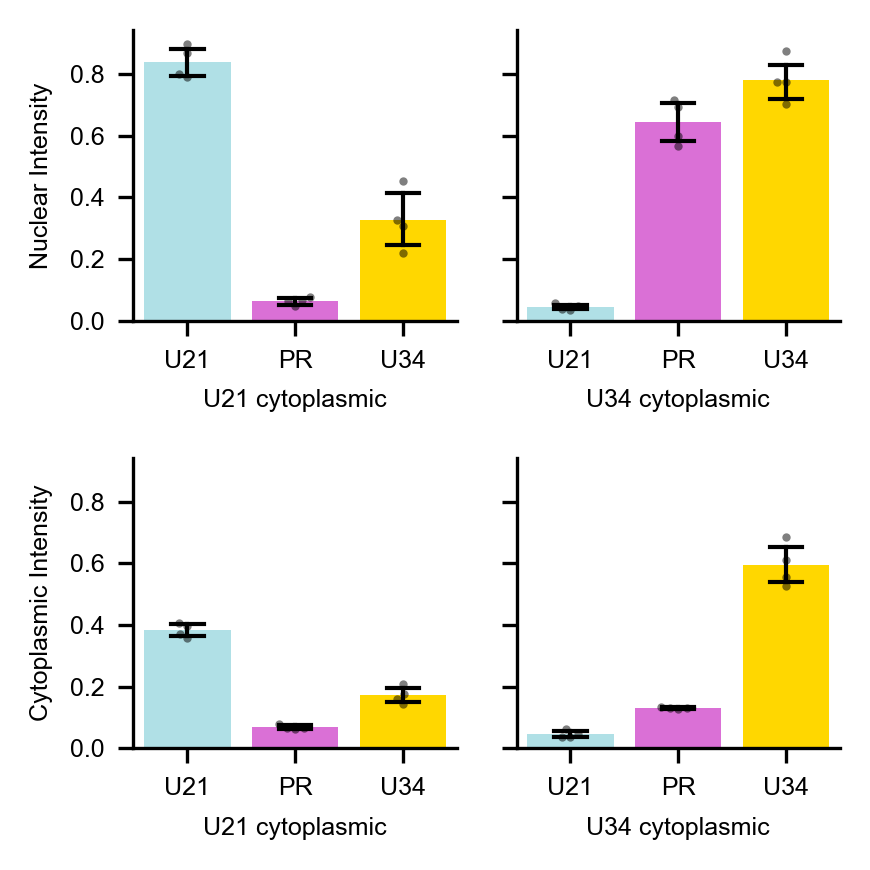

In [176]:
# Plot bar plots of AF546, AF488 and AF647, split by cytoplasmic
cytoplasmic_channels = ["U21 cytoplasmic", "U34 cytoplasmic"]
f, axs = plt.subplots(2, 2, figsize=(3, 3), dpi = 300, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    cytoplasmic_results_channel = cytoplasmic_results[cytoplasmic_results["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=["U21", "PR", "U34"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Nuclear Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=["U21", "PR", "U34"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cytoplasmic-barplot-with-borders.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [137]:
# sample 4 is the best
file_number = 2
results_files = os.listdir(f'../raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 2 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 28262.863006591797, 28655.546295166016), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 76, 4, 2048, 2048)
Loaded ../results/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 2 great_rois.npy
Loaded ../results/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 2 great_cell_borders.npy


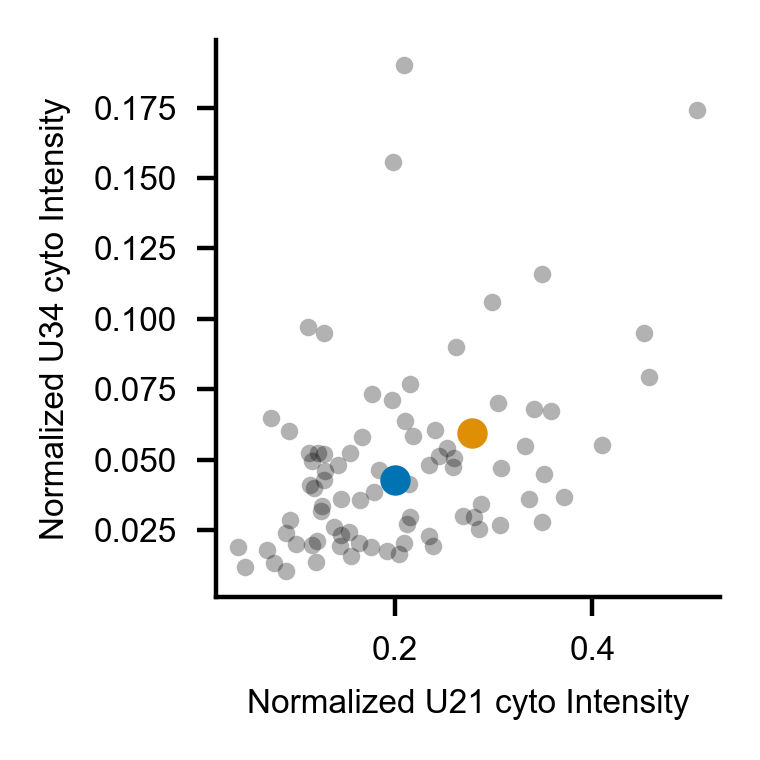

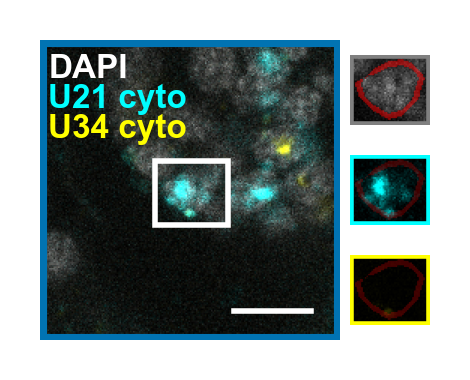

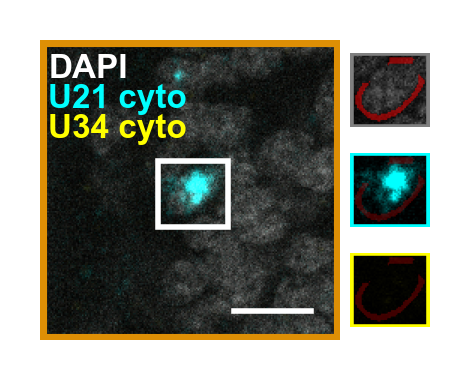

In [142]:
# u34-b3-488 lnc4-b1-546 u21-b5-647
plot_2_channels(results=results[results['cytoplasmic'] == "AF647"], image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF647-border", c2="AF546-border", 
                c1_name="U21 cyto", c2_name="U34 cyto", 
                c1_color="cyan", c2_color="yellow",
                coordinates=[[0.2, 0.06], [0.3, 0.075]],  
                dapi_max=255, c1_max=150, c2_max=150)

## U34-B3-546 & Chymotrypsin-B2-647 & DAPI
- Chymotrypsin = LOC105276652

In [144]:
input = '20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI'
channels = ['AF546', 'AF647']
channel_names = ['U34', 'LOC105276652']
results, cytoplasmic_results, cytoplasmic_results_counts = load_cytoplasmic_cell_counts(input, channels=channels, channel_names=channel_names, normalization=0.00001)
cytoplasmic_results.head()

,image,cytoplasmic,channel,nuclear_intensity,cytoplasmic_intensity,num_cells,channel_name,cytoplasmic_name
0,20250307 B1 Sample 1 Stack.czi,AF546,AF546,0.693547,0.459503,11,U34,U34 cytoplasmic
1,20250307 B1 Sample 1 Stack.czi,AF546,AF647,0.084475,0.026489,11,LOC105276652,U34 cytoplasmic
2,20250307 B1 Sample 1 Stack.czi,AF647,AF546,0.030783,0.034753,8,U34,LOC105276652 cytoplasmic
3,20250307 B1 Sample 1 Stack.czi,AF647,AF647,0.289172,0.082324,8,LOC105276652,LOC105276652 cytoplasmic
4,20250307 B1 Sample 2 Stack.czi,AF546,AF546,0.682757,0.503151,11,U34,U34 cytoplasmic


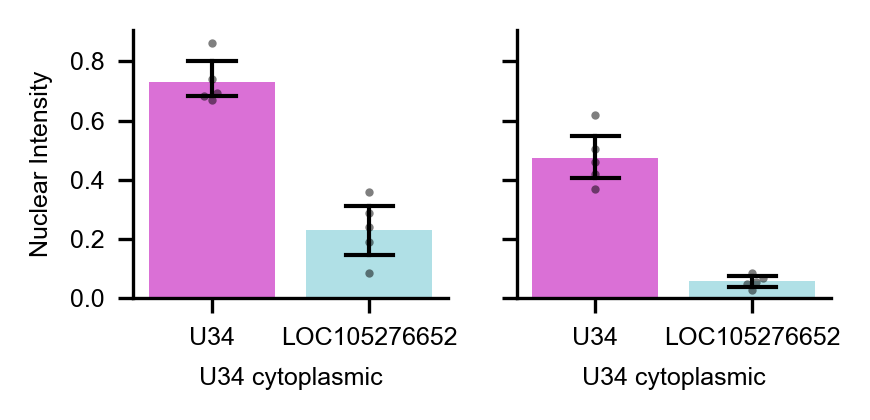

In [145]:
# Plot bar plots of AF546, AF488 and AF647, split by cytoplasmic
cytoplasmic_channel = "U34 cytoplasmic"
cytoplasmic_results_channel = cytoplasmic_results[cytoplasmic_results['cytoplasmic_name'] == cytoplasmic_channel]
f, axs = plt.subplots(1, 2, figsize=(3, 1.5), dpi = 300, sharey=True)
ax = axs[0]
sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, palette=['orchid', 'powderblue'], order=["U34", "LOC105276652"], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
ax.set_ylabel("Nuclear Intensity", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)

ax = axs[1]
sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, palette=['orchid', 'powderblue'], order=["U34", "LOC105276652"], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
ax.set_ylabel("Cytoplasmic Intensity", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cytoplasmic-barplot-with-borders.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

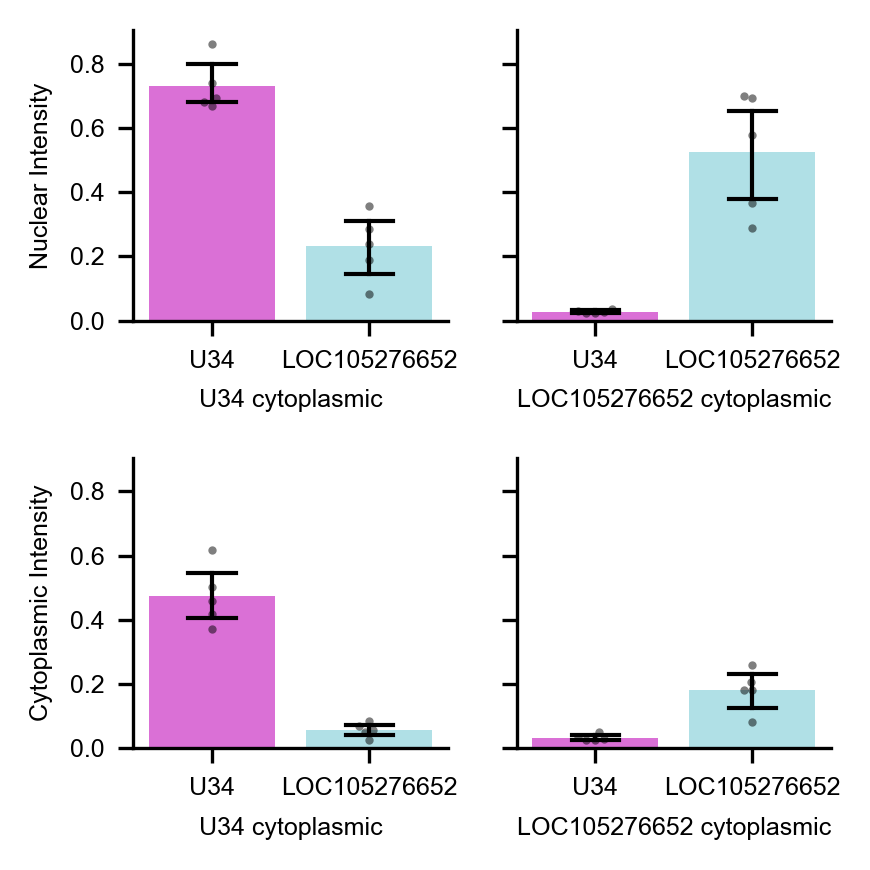

In [146]:
# Plot bar plots of AF546, AF488 and AF647, split by cytoplasmic
cytoplasmic_channels = cytoplasmic_results["cytoplasmic_name"].unique() 
f, axs = plt.subplots(2, 2, figsize=(3, 3), dpi = 300, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    cytoplasmic_results_channel = cytoplasmic_results[cytoplasmic_results["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, palette=['orchid', 'powderblue'], order=["U34", "LOC105276652"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Nuclear Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, palette=['orchid', 'powderblue'], order=["U34", "LOC105276652"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cytoplasmic-barplot-with-borders.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [147]:
file_number = 0
results_files = os.listdir(f'../raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")


# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 0.5, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 202, 3, 2048, 2048)
Loaded ../results/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack_rois.npy
Loaded ../results/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack_cell_borders.npy


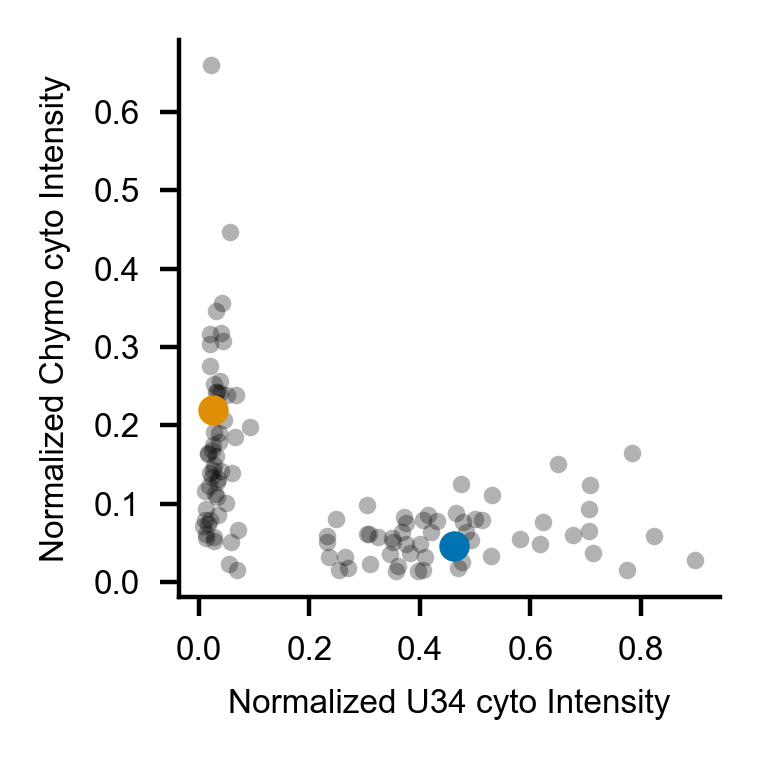

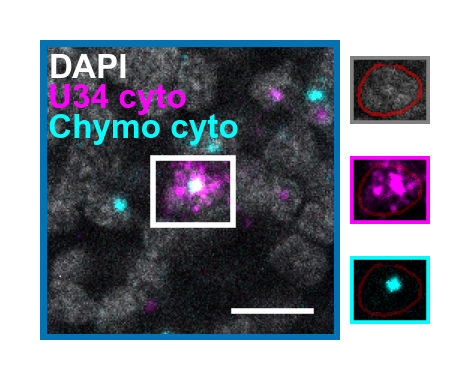

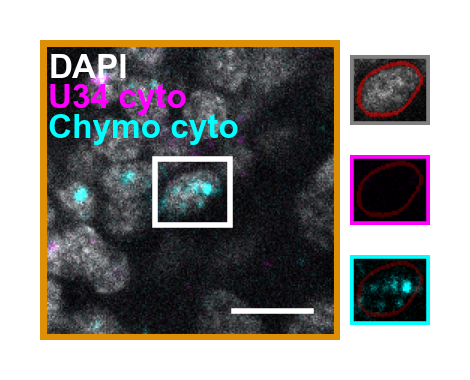

In [149]:
# R2-b3-488 Q1-b1-546 Lnc6-b2-647
plot_2_channels(results=results[results['cytoplasmic'].notnull()], image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-border", c2="AF647-border", 
                c1_name="U34 cyto", c2_name="Chymo cyto", 
                c1_color="magenta", c2_color="cyan",
                coordinates=[[0.5, 0.02], [0.05, 0.2]],  
                dapi_max=255, c1_max=150, c2_max=150)

## R2-b3-488 Q1-b1-546 Lnc6-b2-647

In [120]:
input = '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI'
channels = ['AF488', 'AF546', 'AF647']
channel_names = ['R2-3', 'Q1', 'PR']
results, cytoplasmic_results, cytoplasmic_results_counts = load_cytoplasmic_cell_counts(input, channels=channels, channel_names=channel_names, normalization=0.00001)

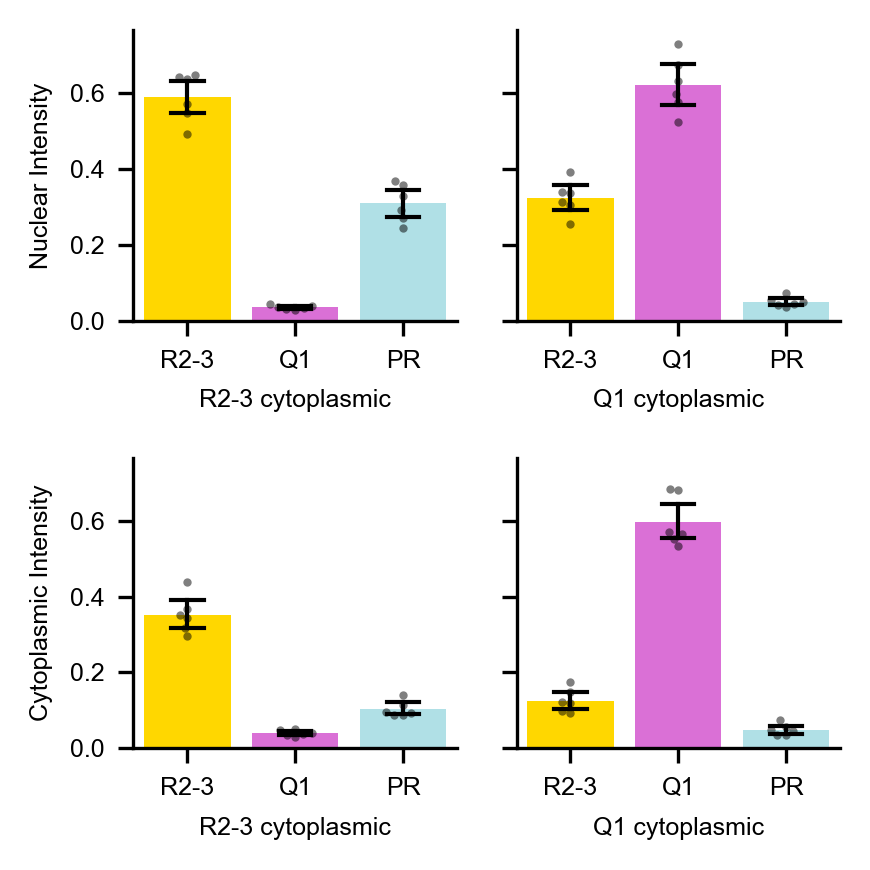

In [121]:
# Plot bar plots of AF546, AF488 and AF647, split by cytoplasmic
cytoplasmic_channels = cytoplasmic_results["cytoplasmic_name"].unique() 
f, axs = plt.subplots(2, 2, figsize=(3, 3), dpi = 300, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    cytoplasmic_results_channel = cytoplasmic_results[cytoplasmic_results["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["R2-3", "Q1", "PR"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Nuclear Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["R2-3", "Q1", "PR"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cytoplasmic-barplot-with-borders.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [84]:
# sample 4 is the best
file_number = 2
results_files = os.listdir(f'../raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 4.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 103, 4, 2048, 2048)
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 4_rois.npy
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 4_cell_borders.npy


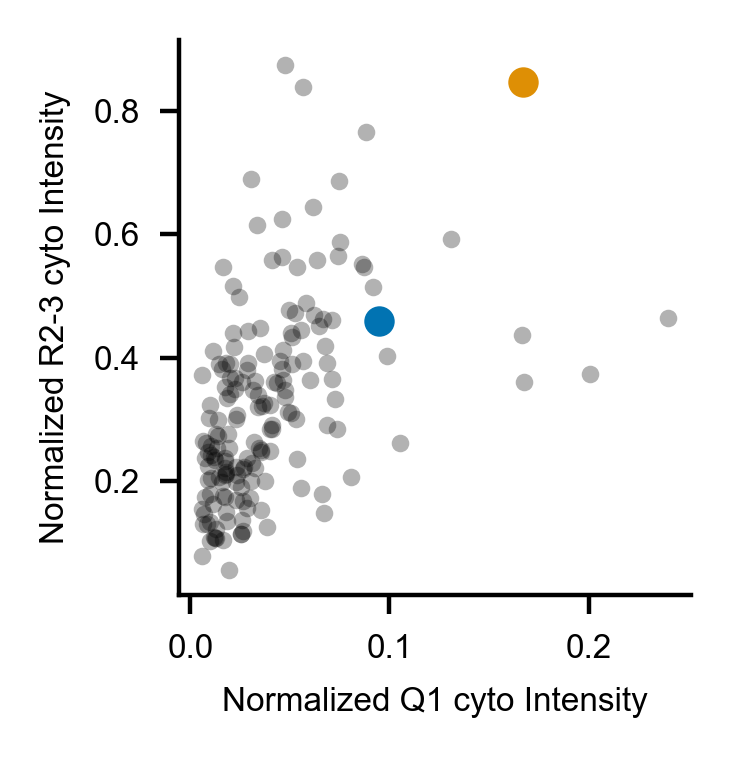

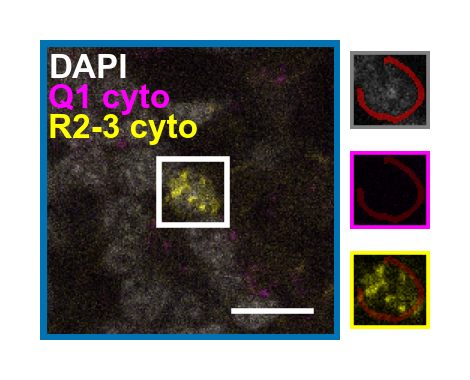

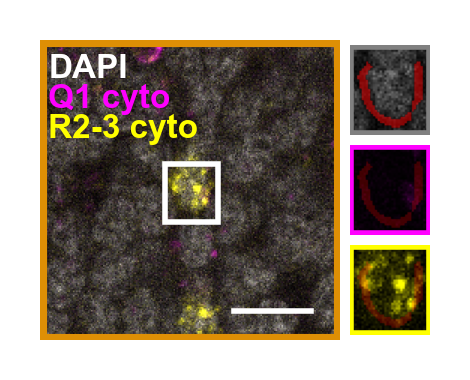

In [85]:
# R2-b3-488 Q1-b1-546 Lnc6-b2-647 
plot_2_channels(results=results[results['cytoplasmic'] == "AF488"], image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-border", c2="AF488-border", 
                c1_name="Q1 cyto", c2_name="R2-3 cyto", 
                c1_color="magenta", c2_color="yellow",
                coordinates=[[0.1, 0.5], [0.1, 0.8]],  
                dapi_max=255, c1_max=150, c2_max=150)

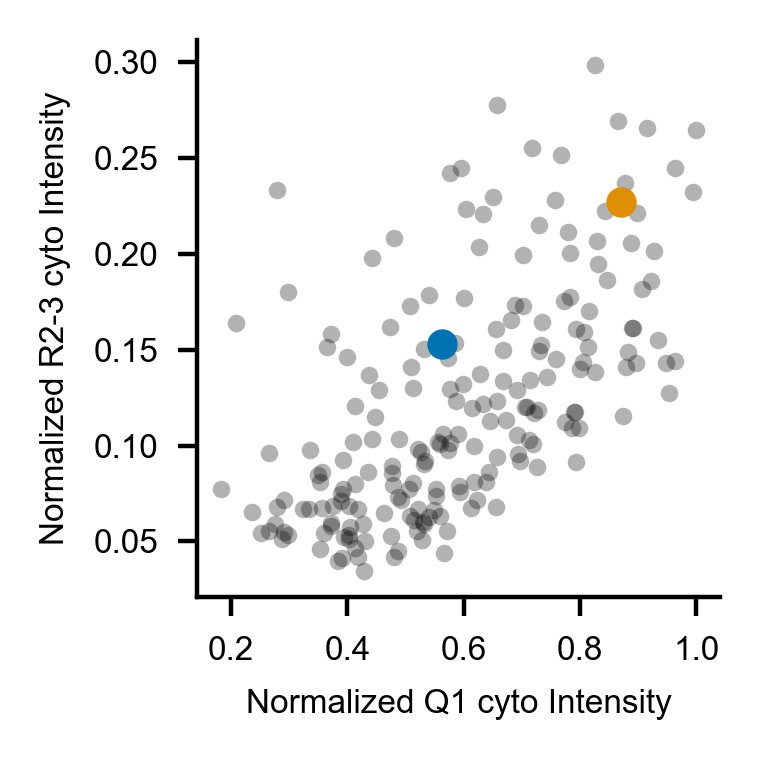

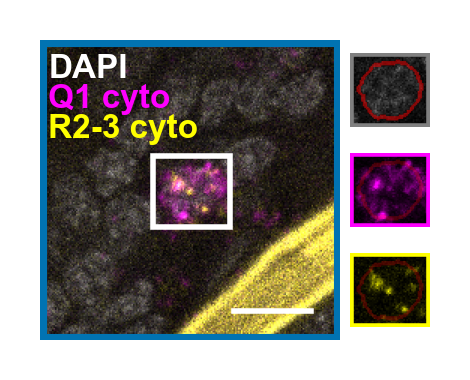

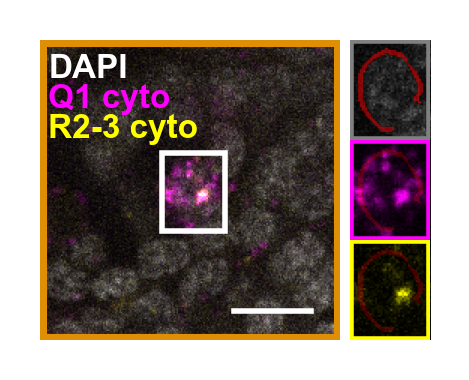

In [60]:
# R2-b3-488 Q1-b1-546 Lnc6-b2-647
plot_2_channels(results=results[results['cytoplasmic'] == "AF546"], image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-border", c2="AF488-border", 
                c1_name="Q1 cyto", c2_name="R2-3 cyto", 
                c1_color="magenta", c2_color="yellow",
                coordinates=[[0.5, 0.5], [0.9, 0.4]],  
                dapi_max=255, c1_max=150, c2_max=150)

## LOC105282603-B3-488 & 9E108-B1-546 & 9E116-B2-647 & DAPI 

In [16]:
input = '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI'
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["LOC105282603", "9E108", "9E116"]
results, cytoplasmic_results, cytoplasmic_results_counts = load_cytoplasmic_cell_counts(input, channels=channels, channel_names=channel_names, normalization=0.0001)
cytoplasmic_results.head()

,image,cytoplasmic,channel,nuclear_intensity,cytoplasmic_intensity,num_cells,channel_name,cytoplasmic_name
0,20250328 5 ZP sample 1.czi,AF488,AF488,0.517573,0.190252,29,LOC105282603,LOC105282603 cytoplasmic
1,20250328 5 ZP sample 1.czi,AF488,AF546,0.109436,0.045504,29,9E108,LOC105282603 cytoplasmic
2,20250328 5 ZP sample 1.czi,AF488,AF647,0.023887,0.028942,29,9E116,LOC105282603 cytoplasmic
3,20250328 5 ZP sample 1.czi,AF546,AF488,0.334975,0.141394,29,LOC105282603,9E108 cytoplasmic
4,20250328 5 ZP sample 1.czi,AF546,AF546,0.710222,0.282064,29,9E108,9E108 cytoplasmic


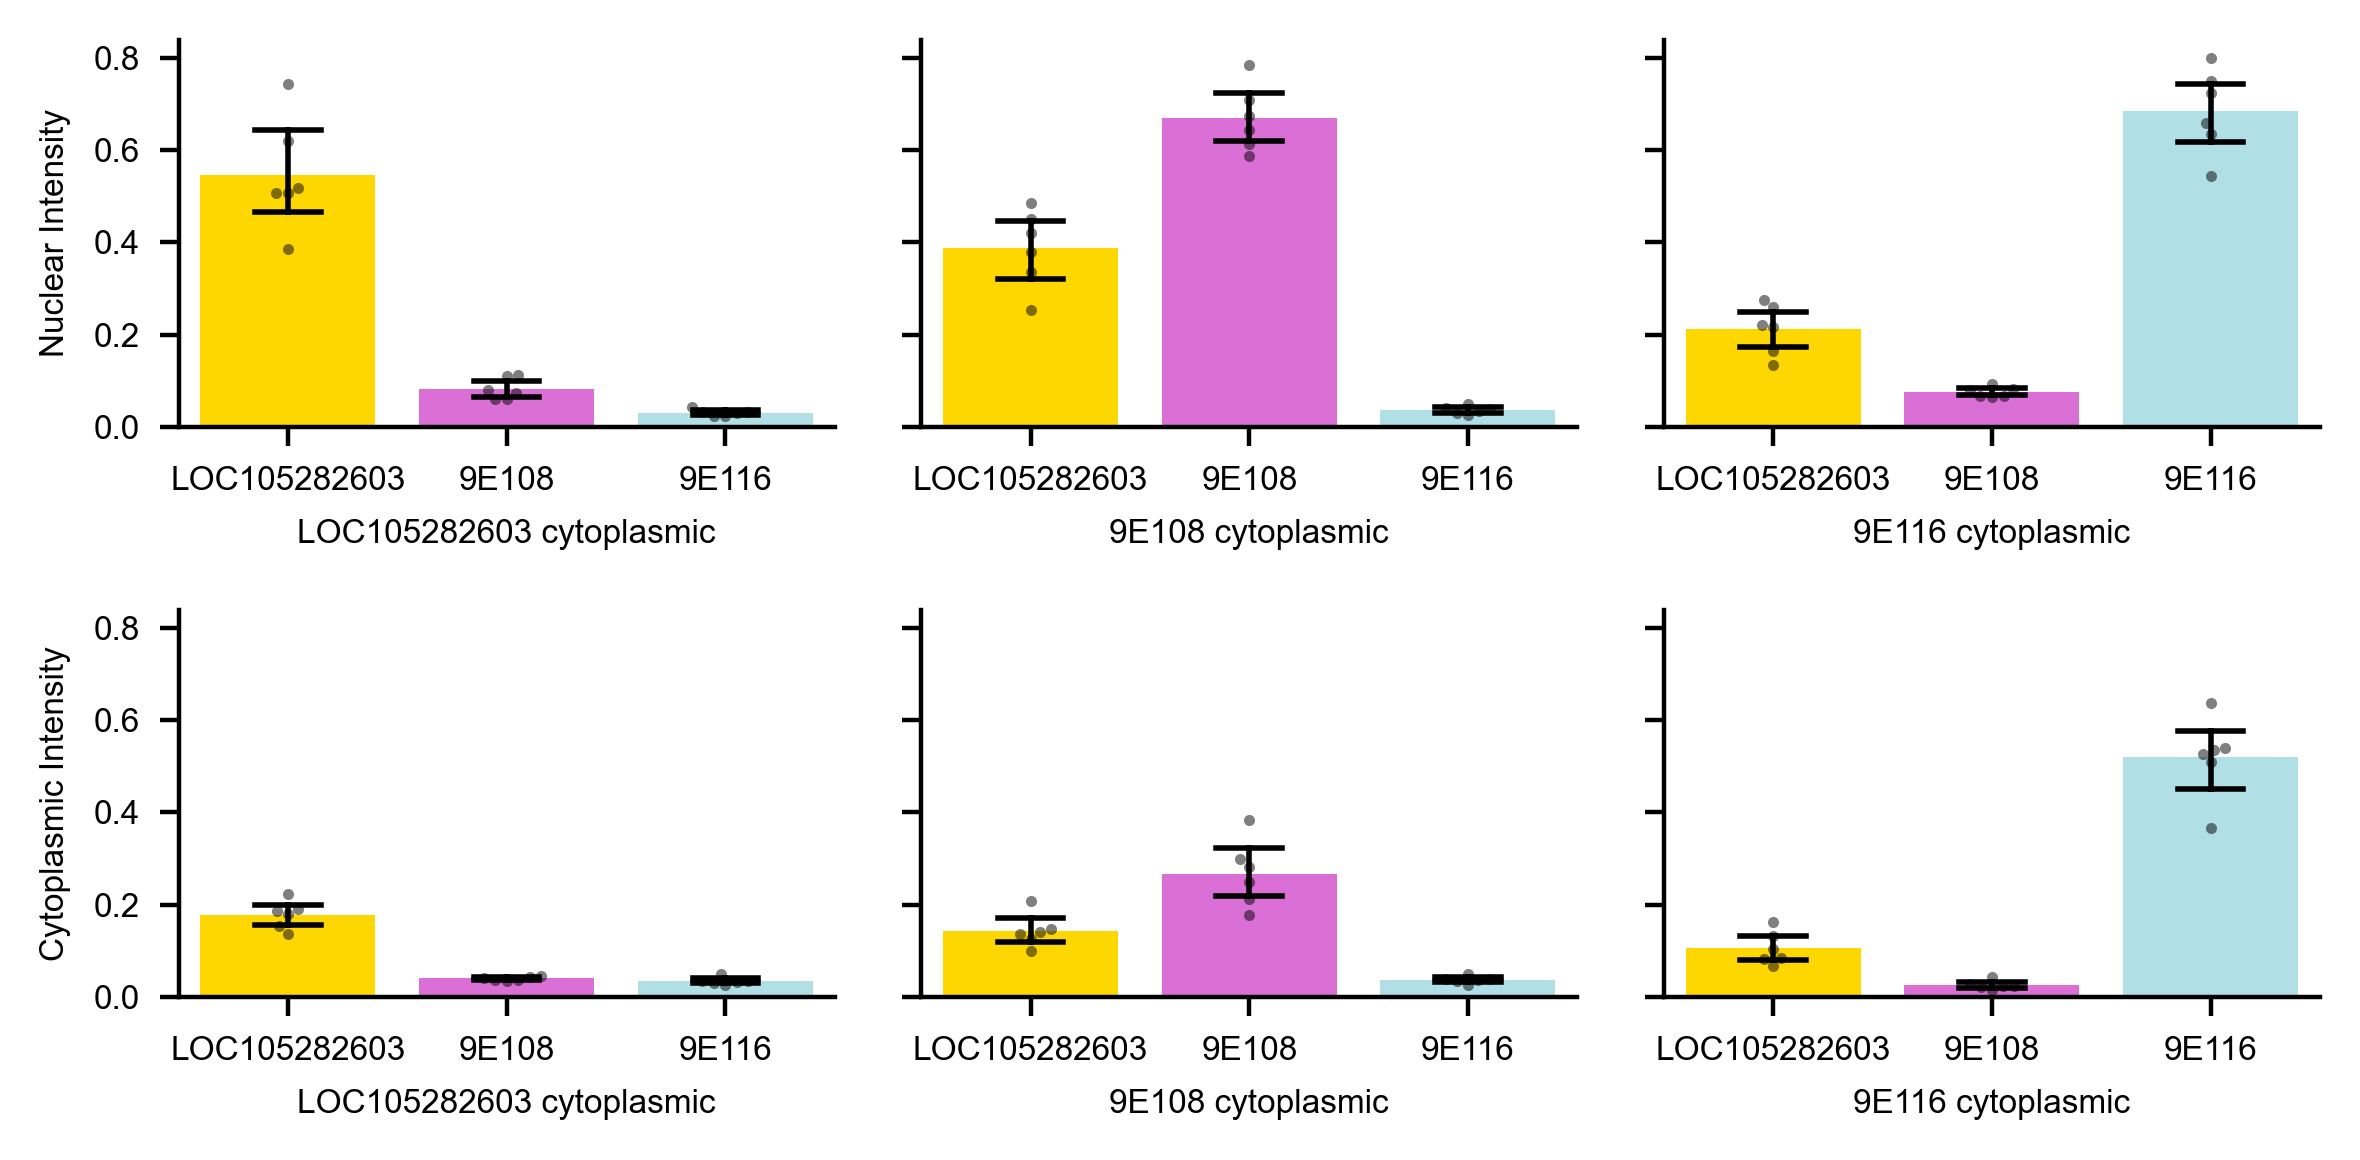

In [17]:
# Plot bar plots of AF546, AF488 and AF647, split by cytoplasmic
cytoplasmic_channels = cytoplasmic_results["cytoplasmic_name"].unique() 
f, axs = plt.subplots(2, 3, figsize=(6, 3), dpi = 400, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    cytoplasmic_results_channel = cytoplasmic_results[cytoplasmic_results["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["LOC105282603", "9E108", "9E116"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Nuclear Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["LOC105282603", "9E108", "9E116"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cytoplasmic-barplot-with-borders.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi

In [25]:
input = '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi'
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E129", "LOC105275104", "9E116"]
results, cytoplasmic_results, cytoplasmic_results_counts = load_cytoplasmic_cell_counts(input, channels=channels, channel_names=channel_names, normalization=0.00001)
cytoplasmic_results.head()

,image,cytoplasmic,channel,nuclear_intensity,cytoplasmic_intensity,num_cells,channel_name,cytoplasmic_name
0,20250328 4 KLF sample 1.czi,AF488,AF488,0.721068,0.288744,18,9E129,9E129 cytoplasmic
1,20250328 4 KLF sample 1.czi,AF488,AF546,0.227872,0.108402,18,LOC105275104,9E129 cytoplasmic
2,20250328 4 KLF sample 1.czi,AF488,AF647,0.133702,0.043927,18,9E116,9E129 cytoplasmic
3,20250328 4 KLF sample 1.czi,AF647,AF488,0.130598,0.133049,36,9E129,9E116 cytoplasmic
4,20250328 4 KLF sample 1.czi,AF647,AF546,0.191372,0.066127,36,LOC105275104,9E116 cytoplasmic


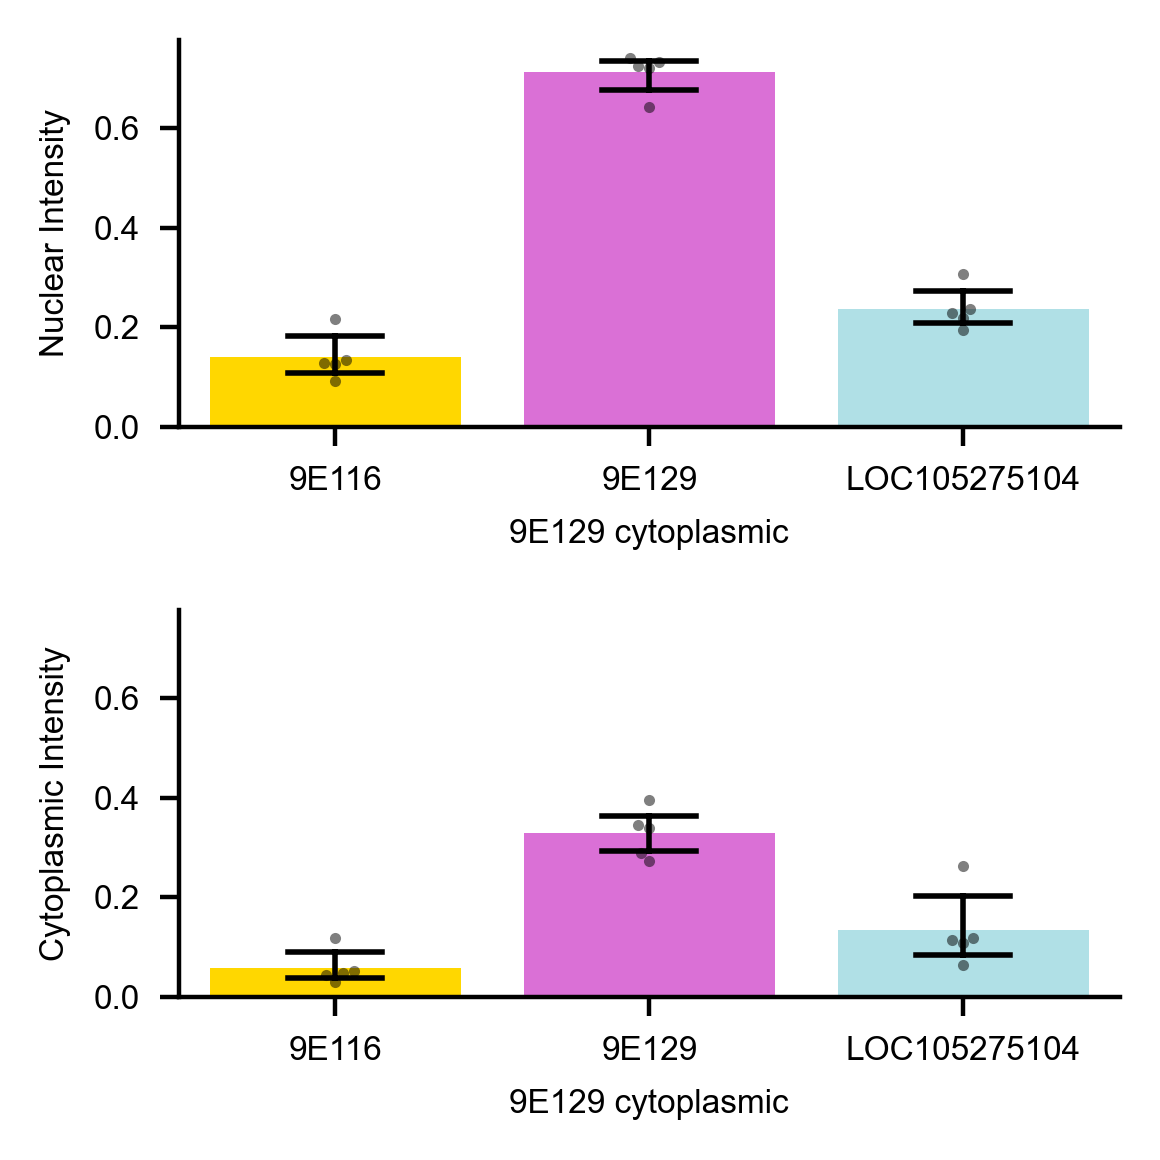

In [32]:
# Plot bar plots of AF546, AF488 and AF647, split by cytoplasmic
cytoplasmic_channels = ["9E129 cytoplasmic"]
f, axs = plt.subplots(2, 1, figsize=(3, 3), dpi = 400, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    cytoplasmic_results_channel = cytoplasmic_results[cytoplasmic_results["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["9E116", "9E129", "LOC105275104"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Nuclear Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["9E116", "9E129", "LOC105275104"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cytoplasmic-barplot-with-borders.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## lnc3-B3-488 & L16-B2-594 & Lnc2-B5-647 & DAPI
PR1-488, L16-594, PR2-647

In [108]:
input = '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI'
channels = ['AF488', 'AF594', 'AF647']
channel_names = ["PR2", "L16", "PR1"]
results, cytoplasmic_results, cytoplasmic_results_counts = load_cytoplasmic_cell_counts(input, channels=channels, channel_names=channel_names, normalization=0.00001)

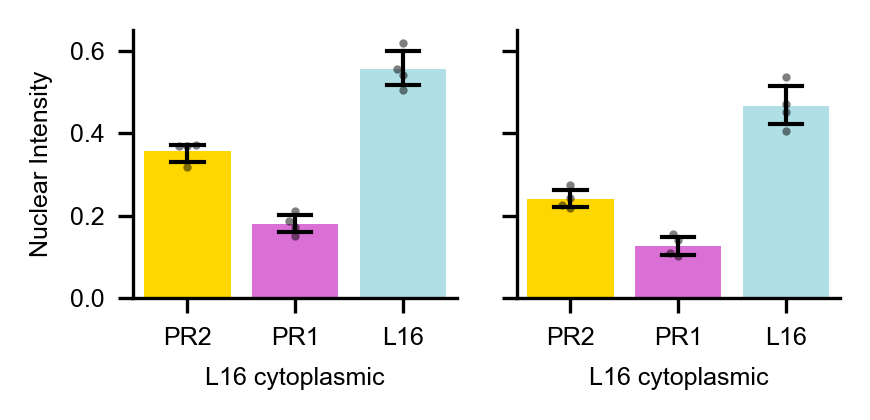

In [109]:
# Plot bar plots of AF546, AF488 and AF647, split by cytoplasmic
f, axs = plt.subplots(1, 2, figsize=(3, 1.5), dpi = 300, sharey=True)
ax = axs[0]
sns.barplot(data=cytoplasmic_results, x="channel_name", y="nuclear_intensity", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["PR2", "PR1", "L16"], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=cytoplasmic_results, x="channel_name", y="nuclear_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"L16 cytoplasmic", fontsize=6)
ax.set_ylabel("Nuclear Intensity", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)

ax = axs[1]
sns.barplot(data=cytoplasmic_results, x="channel_name", y="cytoplasmic_intensity", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=["PR2", "PR1", "L16"], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=cytoplasmic_results, x="channel_name", y="cytoplasmic_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"L16 cytoplasmic", fontsize=6)
ax.set_ylabel("Cytoplasmic Intensity", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cytoplasmic-barplot-with-borders.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## 9E198-B3-488 & 9E197-B1-546 & 9E196-B2-647 & DAPI

In [103]:
input = '20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi'
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E198", "9E197", "9E196"]
results, cytoplasmic_results, cytoplasmic_results_counts = load_cytoplasmic_cell_counts(input, channels=channels, channel_names=channel_names, normalization=0.0001)
cytoplasmic_results.head()

,image,cytoplasmic,channel,nuclear_intensity,cytoplasmic_intensity,num_cells,channel_name,cytoplasmic_name
0,20250325 5 t35 sample 1 great.czi,AF488,AF488,0.820562,0.437016,8,9E198,9E198 cytoplasmic
1,20250325 5 t35 sample 1 great.czi,AF488,AF546,0.070437,0.020352,8,9E197,9E198 cytoplasmic
2,20250325 5 t35 sample 1 great.czi,AF488,AF647,0.042747,0.020423,8,9E196,9E198 cytoplasmic
3,20250325 5 t35 sample 1 great.czi,AF546,AF488,0.271523,0.119023,12,9E198,9E197 cytoplasmic
4,20250325 5 t35 sample 1 great.czi,AF546,AF546,0.880309,0.641856,12,9E197,9E197 cytoplasmic


2025-04-04 10:58:08,240 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-04 10:58:08,244 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-04-04 10:58:08,276 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-04 10:58:08,279 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-04 10:58:08,331 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-04 10:58:08,335 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-04 10:58:08,366 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or 

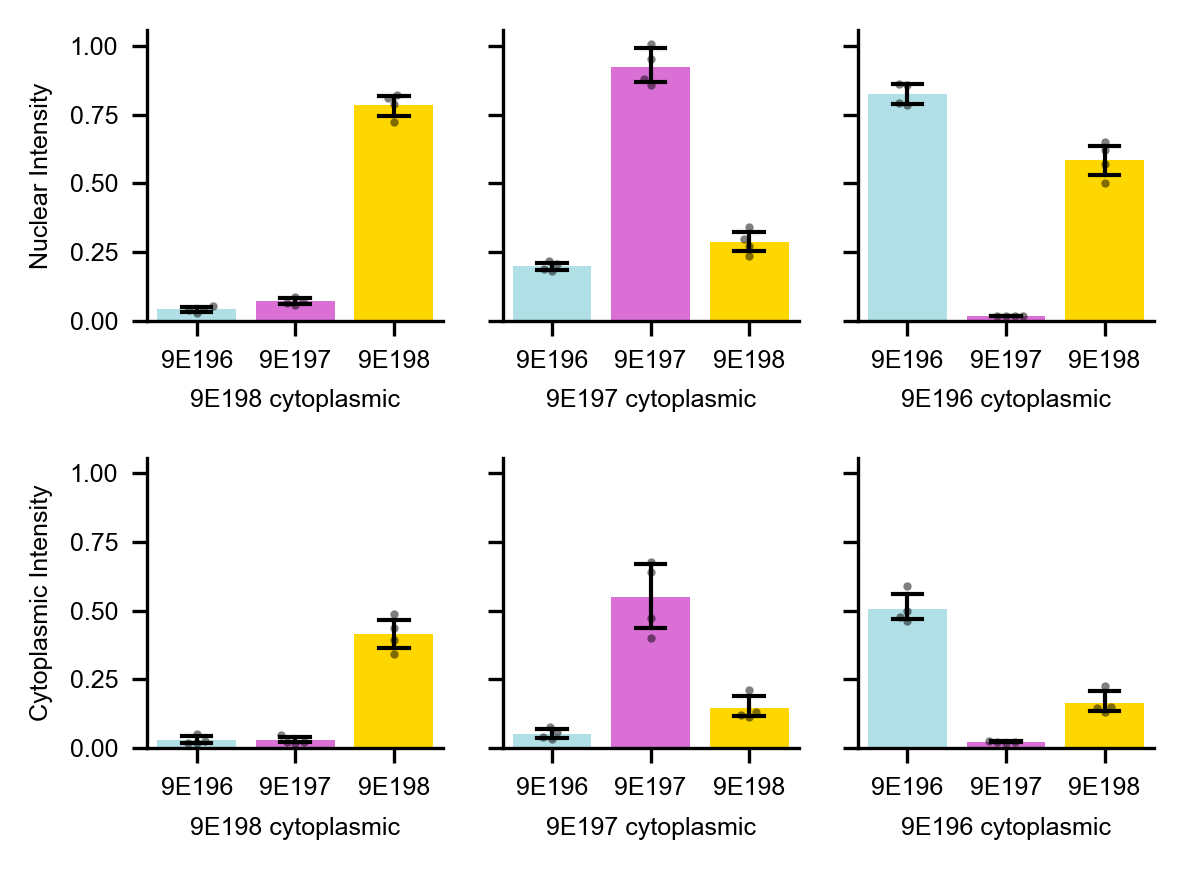

In [107]:
# Plot bar plots of AF546, AF488 and AF647, split by cytoplasmic
cytoplasmic_channels = cytoplasmic_results["cytoplasmic_name"].unique() 
f, axs = plt.subplots(2, 3, figsize=(4, 3), dpi = 300, sharey=True)
for i, cytoplasmic_channel in enumerate(cytoplasmic_channels):
    cytoplasmic_results_channel = cytoplasmic_results[cytoplasmic_results["cytoplasmic_name"] == cytoplasmic_channel]
    ax = axs[0, i]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=["9E196", "9E197", "9E198"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="nuclear_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Nuclear Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax = axs[1, i]
    sns.barplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=["9E196", "9E197", "9E198"], saturation=1, 
                alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
    sns.swarmplot(data=cytoplasmic_results_channel, x="channel_name", y="cytoplasmic_intensity", ax=ax, color='black', alpha=0.5, s=2, legend=False, dodge=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{cytoplasmic_channel}", fontsize=6)
    ax.set_ylabel("Cytoplasmic Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cytoplasmic-barplot-with-borders.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()